In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools

# ---- Load and Preprocess Data ----
train_dir = 'D:/Lung_cancer/train'  # Training directory path
target_size = (224, 224)  # AlexNet input size
num_classes = 3

# Extract file paths and labels
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,  # Temporary batch size
    class_mode='categorical',
    shuffle=False  # To keep track of indices
)
X = np.array(train_generator.filepaths)  # File paths of images
y = np.array(train_generator.classes)    # Corresponding class labels

# ---- Hyperparameter tuning Search Space ----
batch_sizes = [16, 32]
dropout_rates = [0.3, 0.5]
learning_rates = [0.0005, 0.001]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_params = {}
best_accuracy = 0

# Iterate over all combinations of hyperparameters
for batch_size, dropout_rate, learning_rate in itertools.product(batch_sizes, dropout_rates, learning_rates):
    print(f"Testing batch_size={batch_size}, dropout={dropout_rate}, lr={learning_rate}")
    
    fold_accuracies = []
    fold_losses = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}")
        
        # Split into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Load data dynamically
        def load_data(file_paths, labels):
            images = []
            for file in file_paths:
                img = load_img(file, target_size=target_size)
                img = img_to_array(img)
                images.append(img)
            images = np.array(images) / 255.0
            labels = np.eye(num_classes)[labels]
            return images, labels
        
        X_train_images, y_train_labels = load_data(X_train, y_train)
        X_val_images, y_val_labels = load_data(X_val, y_val)
        
        # ---- Define AlexNet Model ----
        def alexnet(input_shape=(224, 224, 3), num_classes=3, dropout_rate=0.5):
            model = models.Sequential()
            
            # 1st Convolutional Layer
            model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
            model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

            # 2nd Convolutional Layer
            model.add(layers.Conv2D(256, (5, 5), activation='relu', padding="same"))
            model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

            # 3rd, 4th, 5th Convolutional Layers
            model.add(layers.Conv2D(384, (3, 3), activation='relu', padding="same"))
            model.add(layers.Conv2D(384, (3, 3), activation='relu', padding="same"))
            model.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
            model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

            # Flatten
            model.add(layers.Flatten())

            # Fully Connected Layers
            model.add(layers.Dense(4096, activation='relu'))
            model.add(layers.Dropout(dropout_rate))
            model.add(layers.Dense(4096, activation='relu'))
            model.add(layers.Dropout(dropout_rate))
            model.add(layers.Dense(num_classes, activation='softmax'))

            return model
        
        model = alexnet(input_shape=(224, 224, 3), num_classes=num_classes, dropout_rate=dropout_rate)
        
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # ---- Train Model ----
        history = model.fit(
            X_train_images, y_train_labels,
            validation_data=(X_val_images, y_val_labels),
            epochs=10,  # Default to 10 epochs
            batch_size=batch_size,
            verbose=1
        )
        
        # ---- Evaluate Model ----
        val_loss, val_accuracy = model.evaluate(X_val_images, y_val_labels, verbose=0)
        print(f"Fold {fold + 1} Accuracy: {val_accuracy * 100:.2f}%")
        print(f"Fold {fold + 1} Loss: {val_loss:.4f}")
        
        fold_accuracies.append(val_accuracy)
        fold_losses.append(val_loss)
    
    # Compute mean accuracy for the current hyperparameter combination
    mean_accuracy = np.mean(fold_accuracies)
    mean_loss = np.mean(fold_losses)
    
    print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%, Mean Loss: {mean_loss:.4f}\n")
    
    # Store best hyperparameters
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = {
            "batch_size": batch_size,
            "dropout": dropout_rate,
            "learning_rate": learning_rate,
            "accuracy": best_accuracy
        }

# ---- Final Best Parameters ----
print("Best Parameters:")
print(best_params)


Found 406 images belonging to 3 classes.
Testing batch_size=16, dropout=0.3, lr=0.0005

Fold 1


C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 826ms/step - accuracy: 0.3806 - loss: 1.3871 - val_accuracy: 0.4634 - val_loss: 1.0707
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 796ms/step - accuracy: 0.3775 - loss: 1.0950 - val_accuracy: 0.4634 - val_loss: 1.0926
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 787ms/step - accuracy: 0.3230 - loss: 1.0980 - val_accuracy: 0.4634 - val_loss: 1.0863
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 785ms/step - accuracy: 0.3795 - loss: 1.0915 - val_accuracy: 0.4634 - val_loss: 1.0812
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 787ms/step - accuracy: 0.3627 - loss: 1.0956 - val_accuracy: 0.4634 - val_loss: 1.0892
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 789ms/step - accuracy: 0.3994 - loss: 1.0955 - val_accuracy: 0.4634 - val_loss: 1.0868
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 786ms/step - accuracy: 0.3191 - loss: 1.1005 - val_accuracy: 0.4634 - val_loss: 1.0928
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 801ms/step - accuracy: 0.3735 - loss: 1.0960 - val_accu

In [1]:
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools

# ---- Load and Preprocess Data ----
train_dir = 'D:/Lung_cancer/train'  # Training directory path
target_size = (224, 224)  # AlexNet input size
num_classes = 3

# Extract file paths and labels
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,  # Temporary batch size
    class_mode='categorical',
    shuffle=False  # To keep track of indices
)
X = np.array(train_generator.filepaths)  # File paths of images
y = np.array(train_generator.classes)    # Corresponding class labels

# ---- Hyperparameter tuning Search Space ----
batch_sizes = [32]
dropout_rates = [0.3, 0.5]
learning_rates = [0.0005, 0.001]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_params = {}
best_accuracy = 0

# Iterate over all combinations of hyperparameters
for batch_size, dropout_rate, learning_rate in itertools.product(batch_sizes, dropout_rates, learning_rates):
    print(f"Testing batch_size={batch_size}, dropout={dropout_rate}, lr={learning_rate}")
    
    fold_accuracies = []
    fold_losses = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}")
        
        # Split into training and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Load data dynamically
        def load_data(file_paths, labels):
            images = []
            for file in file_paths:
                img = load_img(file, target_size=target_size)
                img = img_to_array(img)
                images.append(img)
            images = np.array(images) / 255.0
            labels = np.eye(num_classes)[labels]
            return images, labels
        
        X_train_images, y_train_labels = load_data(X_train, y_train)
        X_val_images, y_val_labels = load_data(X_val, y_val)
        
        # ---- Define AlexNet Model ----
        def alexnet(input_shape=(224, 224, 3), num_classes=3, dropout_rate=0.5):
            model = models.Sequential()
            
            # 1st Convolutional Layer
            model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
            model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

            # 2nd Convolutional Layer
            model.add(layers.Conv2D(256, (5, 5), activation='relu', padding="same"))
            model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

            # 3rd, 4th, 5th Convolutional Layers
            model.add(layers.Conv2D(384, (3, 3), activation='relu', padding="same"))
            model.add(layers.Conv2D(384, (3, 3), activation='relu', padding="same"))
            model.add(layers.Conv2D(256, (3, 3), activation='relu', padding="same"))
            model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

            # Flatten
            model.add(layers.Flatten())

            # Fully Connected Layers
            model.add(layers.Dense(4096, activation='relu'))
            model.add(layers.Dropout(dropout_rate))
            model.add(layers.Dense(4096, activation='relu'))
            model.add(layers.Dropout(dropout_rate))
            model.add(layers.Dense(num_classes, activation='softmax'))

            return model
        
        model = alexnet(input_shape=(224, 224, 3), num_classes=num_classes, dropout_rate=dropout_rate)
        
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # ---- Train Model ----
        history = model.fit(
            X_train_images, y_train_labels,
            validation_data=(X_val_images, y_val_labels),
            epochs=10,  # Default to 10 epochs
            batch_size=batch_size,
            verbose=1
        )
        
        # ---- Evaluate Model ----
        val_loss, val_accuracy = model.evaluate(X_val_images, y_val_labels, verbose=0)
        print(f"Fold {fold + 1} Accuracy: {val_accuracy * 100:.2f}%")
        print(f"Fold {fold + 1} Loss: {val_loss:.4f}")
        
        fold_accuracies.append(val_accuracy)
        fold_losses.append(val_loss)
    
    # Compute mean accuracy for the current hyperparameter combination
    mean_accuracy = np.mean(fold_accuracies)
    mean_loss = np.mean(fold_losses)
    
    print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%, Mean Loss: {mean_loss:.4f}\n")
    
    # Store best hyperparameters
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = {
            "batch_size": batch_size,
            "dropout": dropout_rate,
            "learning_rate": learning_rate,
            "accuracy": best_accuracy
        }

# ---- Final Best Parameters ----
print("Best Parameters:")
print(best_params)


Found 406 images belonging to 3 classes.
Testing batch_size=32, dropout=0.3, lr=0.0005

Fold 1


C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.2912 - loss: 1.1492 - val_accuracy: 0.4634 - val_loss: 1.0778
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3502 - loss: 1.1073 - val_accuracy: 0.4634 - val_loss: 1.0891
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 991ms/step - accuracy: 0.3799 - loss: 1.0958 - val_accuracy: 0.4634 - val_loss: 1.0838
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3437 - loss: 1.0980 - val_accuracy: 0.4634 - val_loss: 1.0902
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 996ms/step - accuracy: 0.3678 - loss: 1.0961 - val_accuracy: 0.4634 - val_loss: 1.0938
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3347 - loss: 1.0995 - val_accuracy: 0.4634 - val_loss: 1.0940
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3699 - loss: 1.0987 - val_accuracy: 0.4634 - val_loss: 1.0913
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 999ms/step - accuracy: 0.3386 - loss: 1.0981 - val_accuracy: 0.4634 - 

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---- Paths ----
train_dir = 'D:/Lung_cancer/train'
val_dir = 'D:/Lung_cancer/LC25000_sampled'
test_dir = 'D:/Lung_cancer/test'

# ---- Hyperparameters ----
batch_size = 32
dropout_rate = 0.3
learning_rate = 0.0005
target_size = (224, 224)  # Standard AlexNet input size
num_classes = 3  # Assuming 3 classes for lung cancer

# ---- Data Preprocessing ----
datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=True
)
val_generator = datagen.flow_from_directory(
    val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)
test_generator = datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

# ---- Define AlexNet Model ----
model = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((3, 3), strides=2),
    
    layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=2),
    
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=2),
    
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(num_classes, activation='softmax')
])

# ---- Compile Model ----
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# ---- Train Model ----
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size=batch_size,
    verbose=1
)

# ---- Evaluate Model ----
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Evaluate for training
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the final model
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")


Found 406 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 103 images belonging to 3 classes.


C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3166 - loss: 1.1591 - val_accuracy: 0.3333 - val_loss: 1.1022
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.3979 - loss: 1.0926 - val_accuracy: 0.3333 - val_loss: 1.1005
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.3729 - loss: 1.0947 - val_accuracy: 0.3333 - val_loss: 1.1021
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3782 - loss: 1.0958 - val_accuracy: 0.3333 - val_loss: 1.1041
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3840 - loss: 1.0915 - val_accuracy: 0.3333 - val_loss: 1.1027
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3915 - loss: 1.0941 - val_accuracy: 0.3333 - val_loss: 1.1026
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3530 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.1038
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3561 - loss: 1.0970 - val_accuracy: 0.3333 - val_loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 837ms/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.50
Nor - AUC: 0.50
Squamous_carcinoma - AUC: 0.50


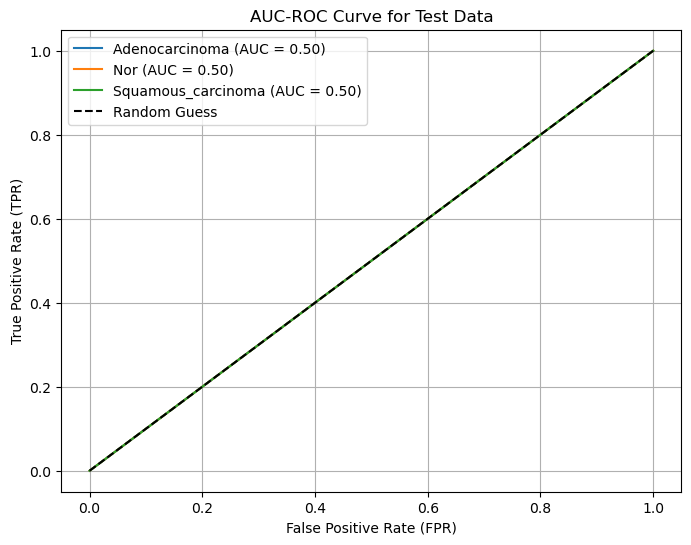


Macro-Averaged Test AUC: 0.50


In [8]:
# Predict probabilities for the test dataset
test_predictions =model.predict(test_generator, verbose=1)

# True labels from the test generator
test_true_labels = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
test_true_labels_binarized = label_binarize(test_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for Test Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(test_true_labels_binarized, test_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 312ms/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.50
Nor - AUC: 0.50
Squamous_carcinoma - AUC: 0.50


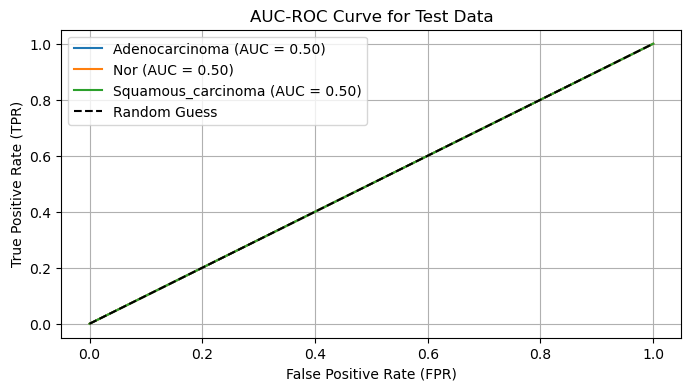


Macro-Averaged Test AUC: 0.50


In [6]:
# Predict probabilities for the test dataset
val_predictions =model.predict(val_generator, verbose=1)

# True labels from the test generator
val_true_labels = val_generator.classes  # True class labels
class_labels = list(val_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
val_true_labels_binarized = label_binarize(val_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for Test Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(val_true_labels_binarized, val_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---- Paths ----
train_dir = 'D:/Lung_cancer/train'
val_dir = 'D:/Lung_cancer/LC25000_sampled'
test_dir = 'D:/Lung_cancer/test'

# ---- Hyperparameters ----
batch_size = 32
dropout_rate = 0.3
learning_rate = 0.0005
target_size = (224, 224)  # Standard AlexNet input size
num_classes = 3  # Assuming 3 classes for lung cancer

# ---- Data Preprocessing ----
datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = datagen.flow_from_directory(
    train_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=True
)
val_generator = datagen.flow_from_directory(
    val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)
test_generator = datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

# ---- Define AlexNet Model ----
model = models.Sequential([
    layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((3, 3), strides=2),
    
    layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=2),
    
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((3, 3), strides=2),
    
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(dropout_rate),
    layers.Dense(num_classes, activation='softmax')
])

# ---- Compile Model ----
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# ---- Train Model ----
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size=batch_size,
    verbose=1
)

# ---- Evaluate Model ----
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Evaluate for training
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the final model
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")


Found 406 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 103 images belonging to 3 classes.


C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.3402 - loss: 1.2754 - val_accuracy: 0.3333 - val_loss: 1.0983
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3326 - loss: 1.0980 - val_accuracy: 0.3333 - val_loss: 1.1014
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.4102 - loss: 1.0927 - val_accuracy: 0.3333 - val_loss: 1.0991
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.3801 - loss: 1.0975 - val_accuracy: 0.3333 - val_loss: 1.0992
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.3977 - loss: 1.0941 - val_accuracy: 0.3333 - val_loss: 1.1013
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.3858 - loss: 1.0924 - val_accuracy: 0.3333 - val_loss: 1.1015
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3679 - loss: 1.0957 - val_accuracy: 0.3333 - val_loss: 1.1027
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.3634 - loss: 1.0978 - val_accuracy: 0.3333 - val_loss:

In [3]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Predicting on validation data
val_predictions = model.predict(val_generator)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = val_generator.classes

# Predicting on test data
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes
print("🔍 Validation Data Metrics:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_generator.class_indices.keys()))

print("🔍 Test Data Metrics:")
print(classification_report(test_true_labels, test_pred_labels, target_names=test_generator.class_indices.keys()))

# Additional individual metrics for better control
print("Validation Accuracy:", accuracy_score(val_true_labels, val_pred_labels))
print("Validation Precision:", precision_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation F1-Score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))

print("Test Accuracy:", accuracy_score(test_true_labels, test_pred_labels))
print("Test Precision:", precision_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test Recall:", recall_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test F1-Score:", f1_score(test_true_labels, test_pred_labels, average='weighted'))

47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 331ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 689ms/step
🔍 Validation Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.33      1.00      0.50       500
               Nor       0.00      0.00      0.00       500
Squamous_carcinoma       0.00      0.00      0.00       500

          accuracy                           0.33      1500
         macro avg       0.11      0.33      0.17      1500
      weighted avg       0.11      0.33      0.17      1500

🔍 Test Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.38      1.00      0.55        39
               Nor       0.00      0.00      0.00        31
Squamous_carcinoma       0.00      0.00      0.00        33

          accuracy                           0.38       103
         macro avg       0.13      0.33      0.18       103
      weighted avg       0.14      0.38      0.21       103

Validation Accuracy: 0.33

C:\Users\Milanjyoti\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Milanjyoti\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Milanjyoti\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Milanjyoti\anaco